# 1. Initial Setup and Library Imports
In this section all the libraries and modules that will be used throughout the project are imported.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from imblearn.over_sampling import SMOTE

# Sets the style for seaborn plots for a nicer look
sbn.set_style('whitegrid')

# 2. Data Loading and Data Cleaning
At this phase, the dataset is loaded from `'fetal_health.csv'`. Two initial cleaning and preparation steps are performed:


1.   The `severe_decelerations` column is deleted due to its zero variance.
2.   The target column `fetal_health` is converted to `category` data type for semantic correctness and memory-optimization



In [2]:
# Load the dataset
df = pd.read_csv('fetal_health.csv')

# Remove the column with zero variance
df = df.drop('severe_decelerations', axis=1)

# Convert the target column to the 'category' type
df['fetal_health'] = df['fetal_health'].astype('category')

# Display the DataFrame info to confirm the changes
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'fetal_health.csv'

# 3. Exploratory Data Analysis - Class Distribution

Visualization of the target variable's distribution is essential to confirm the class imbalance(
Class 1 disparity), which justifies the use of balancing techniques like **SMOTE**.

In [ ]:
plt.figure(figsize=(8, 6))
sbn.countplot(x='fetal_health', data=df)
plt.title('Distribution of Fetal Health Classes', fontsize=16)
plt.xlabel('Fetal Health Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# 4. Preparing Data for Modeling

The dataset is separated into features (`X`) and a target (`y`). Following this, the data is split into training and testing sets with an 80/20 ratio. Stratification (`stratify=y`) is used to ensure the proportion of classes is maintained in both samples, crucial for a fair model evaluation.

In [ ]:
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Balancing Classes with SMOTE

The **SMOTE** (Synthetic Minority Over-sampling Technique) is applied **only to the training set**. This application corrects the class imbalance by generating synthetic examples of the minority classes, allowing the model to learn their patterns effectively without introducing bias into the test set.

In [ ]:
print("Class distribution before SMOTE:", y_train.value_counts().sort_index())

smote = SMOTE(random_state=42)
X_train_resamp, y_train_resamp = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:", y_train_resamp.value_counts().sort_index())

# 6. Model Training and Hyperparameter Tuning with GridSearchCV

`GridSearchCV` is used to find the optimal version of the Decision Tree. It will test various hyperparameter combinations using 10-fold cross-validation (`cv=10`) to find the model with the highest `f1-score macro`, a robust metric for imbalanced problems, focusing on better recall and precision fits.

In [7]:
# Define the base classifier
clf = DecisionTreeClassifier(random_state=42)

# Define the parameter grid to test
grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 7, 10, 12],
}

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=clf,
                           param_grid=grid_params,
                           cv=10,
                           scoring='f1_macro',
                           n_jobs=-1)

# Run the search (processing time varies depending on hardware)
print("Searching for best parameters...")
grid_search.fit(X_train_resamp, y_train_resamp)
print("Search finished!")

Searching for best parameters...
Search finished!


# 7. Evaluating the Best Model

After the search, the best parameters found are analyzed, and the final model's performance is evaluated on the test set. Providing an honest measure of how the model will behave with new, unseen data.

Best parameters found:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

Best F1-score (macro) during search:
0.9641801066099871

=============== Performance on Test Set ===============

Accuracy: 0.903755868544601

Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.93      0.94       332
         2.0       0.67      0.80      0.73        59
         3.0       0.88      0.86      0.87        35

    accuracy                           0.90       426
   macro avg       0.84      0.86      0.85       426
weighted avg       0.91      0.90      0.91       426



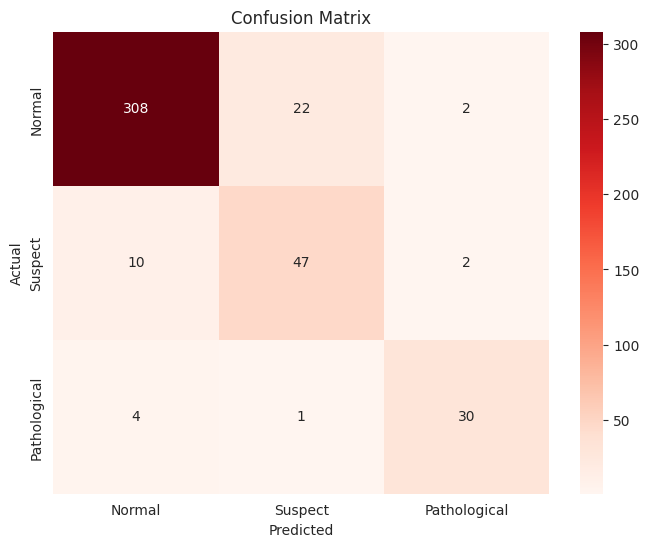

In [18]:
# Display the best results from the search
print("Best parameters found:")
print(grid_search.best_params_)
print("\nBest F1-score (macro) during search:")
print(grid_search.best_score_)

# Uses the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Display the final evaluation metrics
print("\n=============== Performance on Test Set ===============")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("=========================================================")

#Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sbn.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal','Suspect','Pathological'], yticklabels=['Normal','Suspect','Pathological'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 8. Decision Tree Visualization

The logical structure of the final decision tree is visualized. This allows for interpretation of the decision path the model has learned.

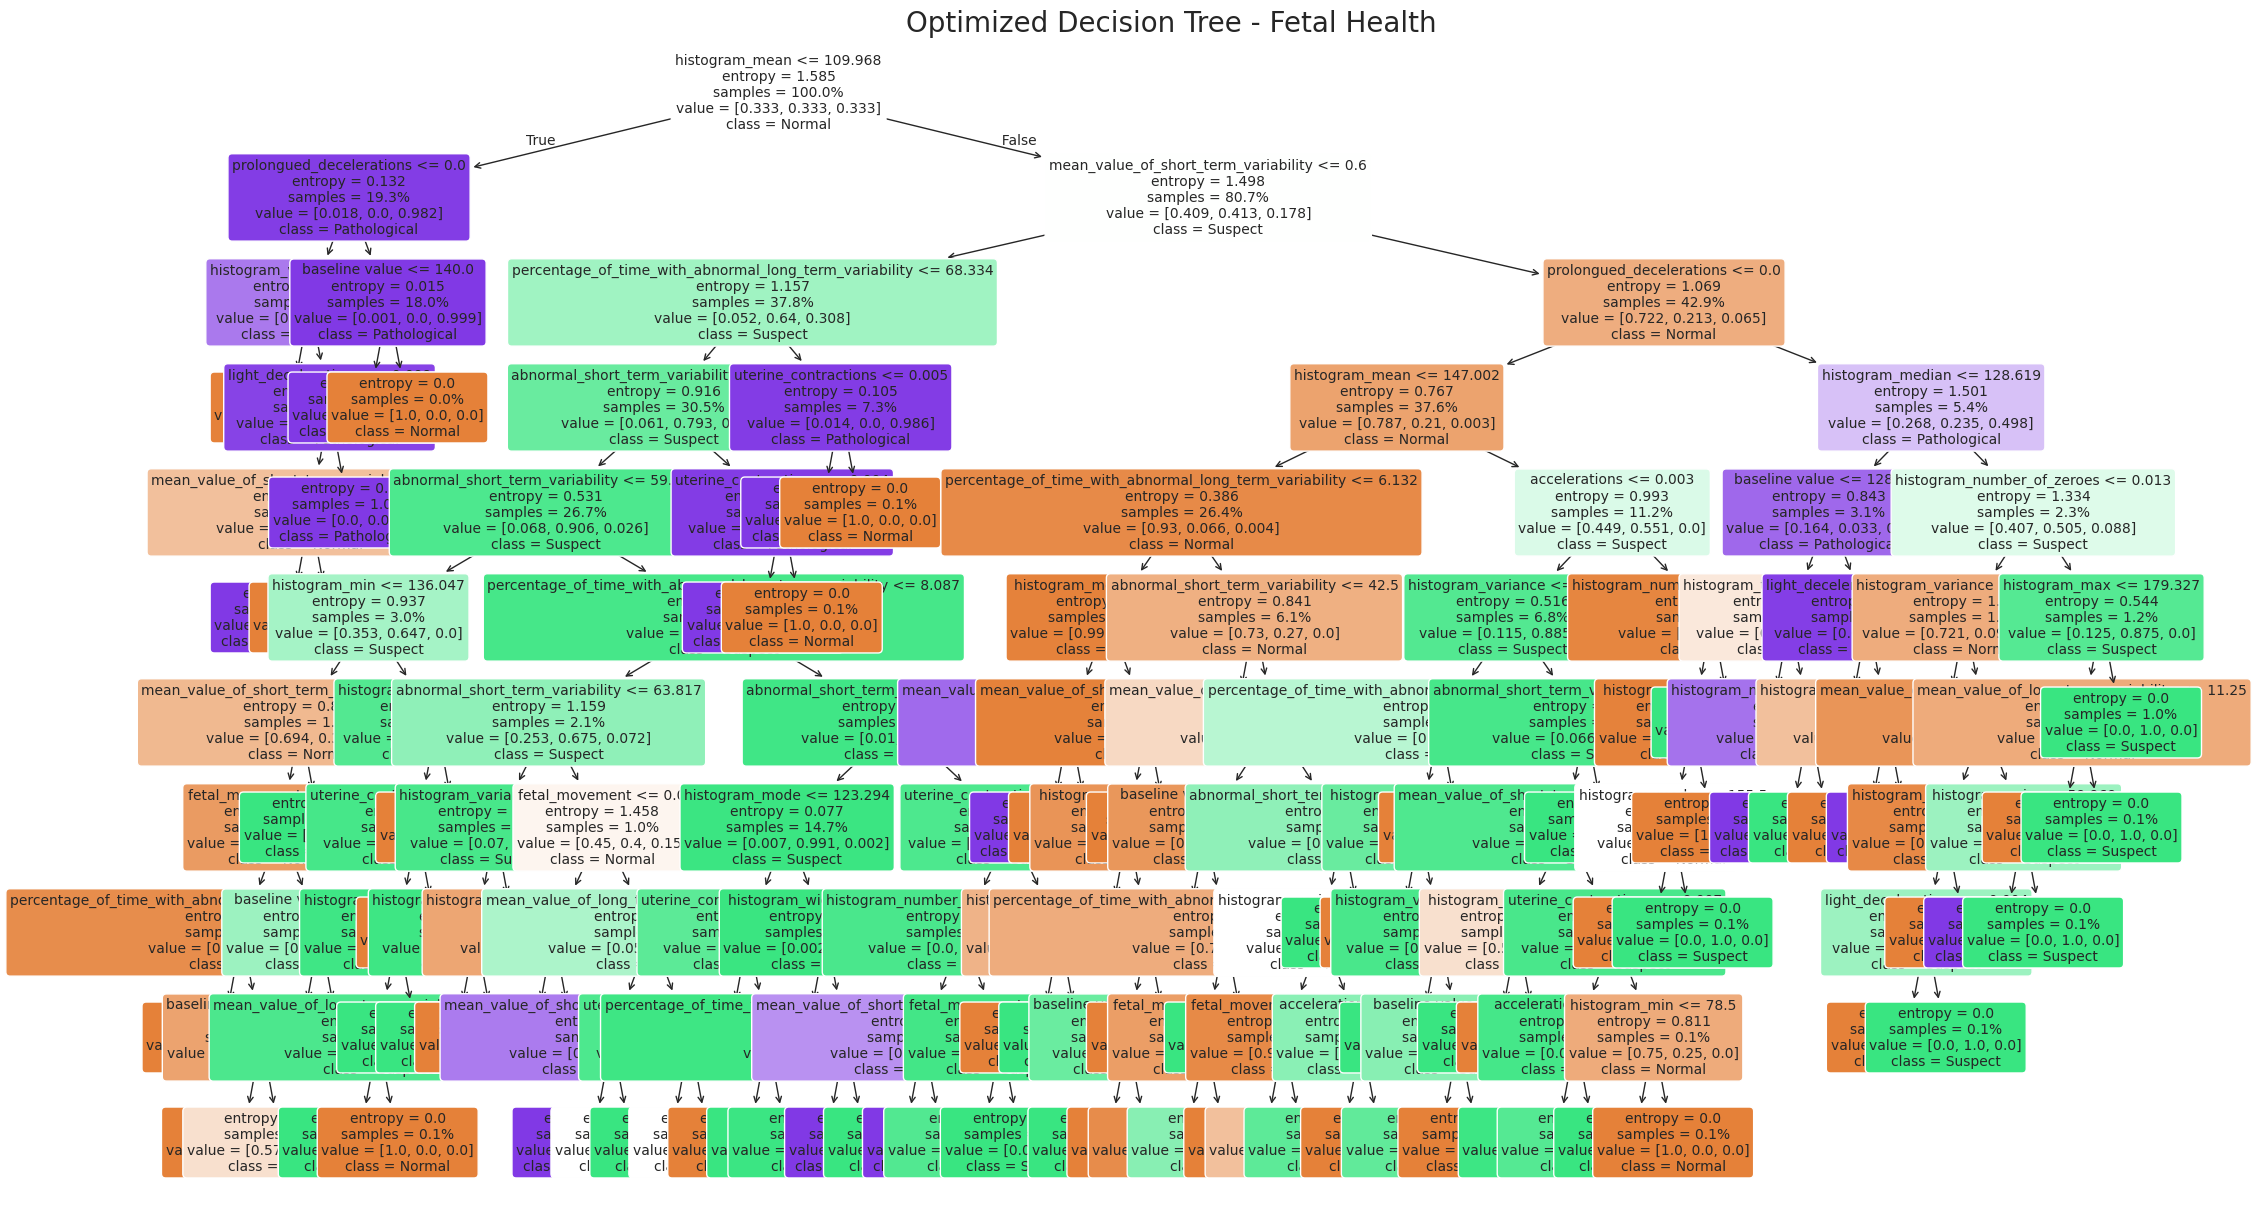

In [27]:
#Plot the decision tree
plt.figure(figsize=(25, 15))
plot_tree(decision_tree=best_model,
          feature_names=X.columns.tolist(),
          class_names=['Normal', 'Suspect', 'Pathological'],
          proportion=True,
          filled=True,
          rounded=True,
          fontsize=10)

plt.title("Optimized Decision Tree - Fetal Health", fontsize=20)
plt.show()

# 9. Feature Importance Analysis

Finally, an investigation is conducted to determine *which* data characteristics were most influential for the model's decisions. This bar chart helps to understand the model's internal logic and extracting insights about the m**ost relevant indicators** of fetal health.

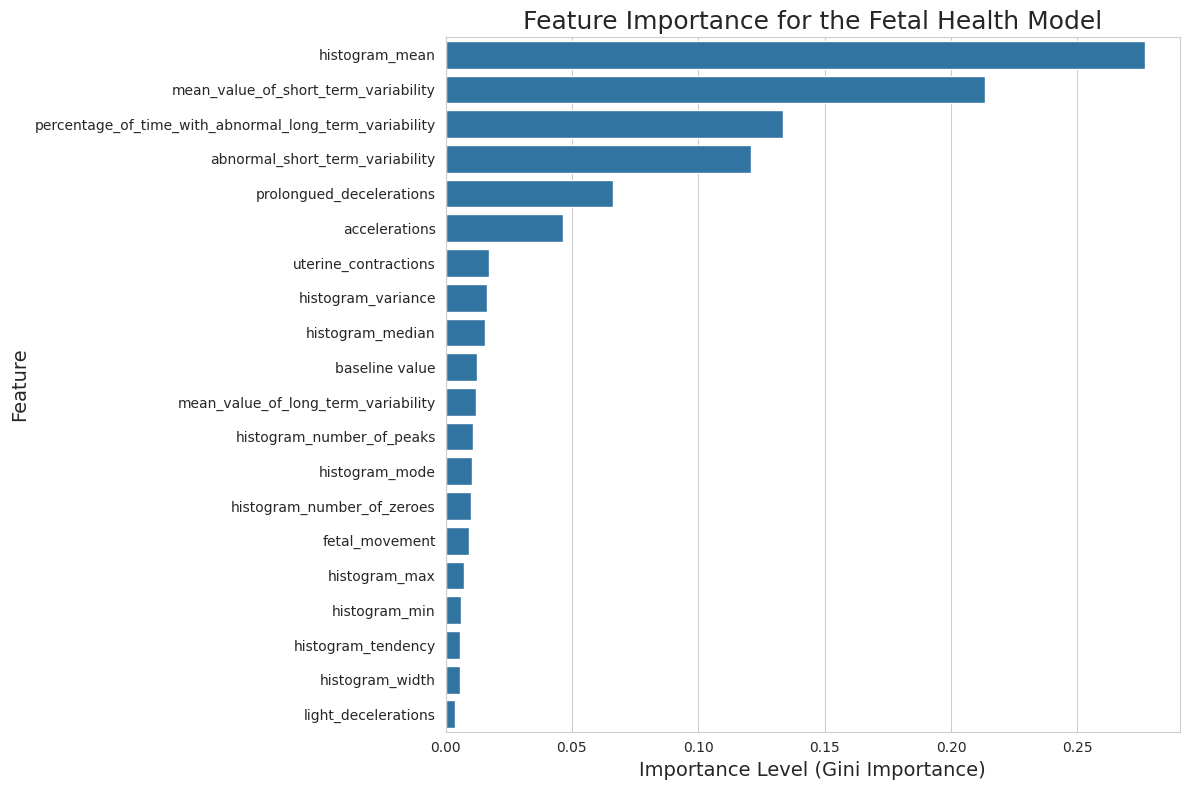

In [24]:
# Extract and organize importance data
importances = best_model.feature_importances_
feature_names = X.columns.tolist()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the analysis
plt.figure(figsize=(12, 8))
sbn.barplot(x='Importance', y='Feature', data=sorted_feature_importance_df)
plt.title('Feature Importance for the Fetal Health Model', fontsize=18)
plt.xlabel('Importance Level (Gini Importance)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()